In [ ]:
%pip install requests
%pip install beautifulsoup4

<!DOCTYPE html>

<html class="doc-desktop" lang="ro">
<head>
<meta charset="utf-8"/>
<title>Telefoane Mobile. Afla Preturile! - eMAG.ro</title>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=5.0" name="viewport"/>
<meta content="Iti doresti un telefon mobil nou, in rate? La eMAG, telefoanele mobile au preturi avantajoase. Cumpara acum si beneficiezi de plata in rate, deschidere colet, easybox, retur gratuit 30 de zile -Instant Money Back." name="description"/><meta content="telefoane, mobile., afla, preturile!, emag.ro" name="keywords"/><meta content="200852986592727" property="fb:app_id"/><meta content="715999269243-k0q6sd28k8sqff1kd4slp1ui39tbi1b6.apps.googleusercontent.com" name="google-signin-client_id"/><meta content="#005EB8" name="theme-color"/><meta content="eMAG.ro" name="apple-mobile-web-app-title"/><meta content="yes" name="apple-mobile-web-app-capable"/><meta content="black" name="apple-mobile-web-app-status-bar-style"/><meta content="noodp" name="robot
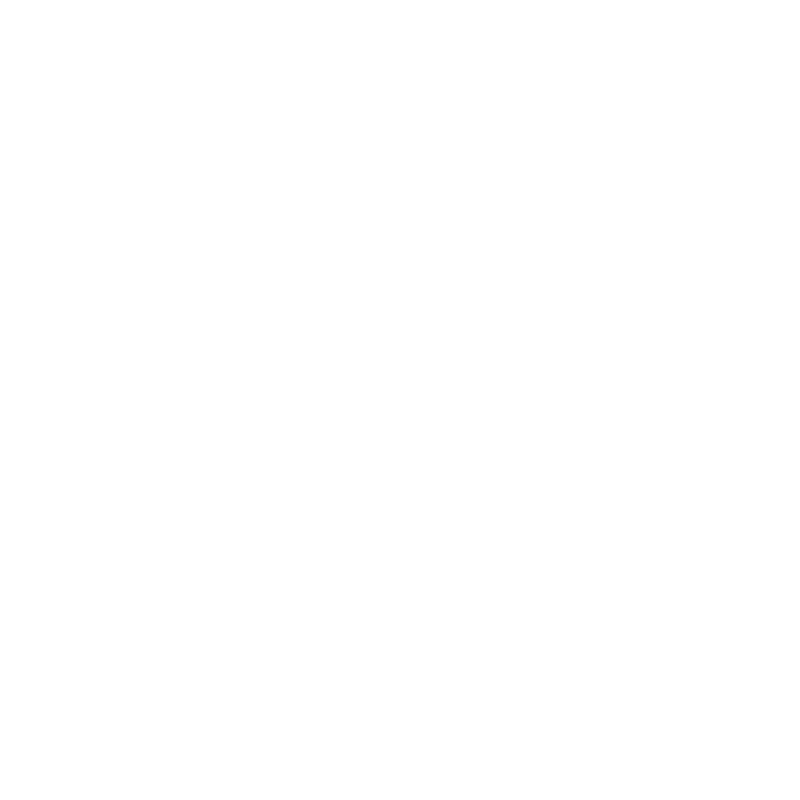

In [159]:
import requests
from bs4 import BeautifulSoup

# url = 'https://www.emag.ro/search/sony%20xm5?ref=effective_search'
url = 'https://www.emag.ro/telefoane-mobile/c'
response = requests.get(url)
html_content = response.text

soup = BeautifulSoup(html_content, 'html.parser')
product_links = soup.find_all('a', class_='card-v2-title semibold mrg-btm-xxs js-product-url')

# Raw html content of the page
print(soup)

In [160]:
import re

In [166]:
def get_reviews(new_product_url):
    product_response = requests.get(new_product_url)
    product_html = product_response.text
    product_soup = BeautifulSoup(product_html, 'html.parser')

    # --------------------- product title ---------------------

    product_title = product_soup.find('h1', class_='page-title').get_text()
    # get rid of multiple whitespaces and \n
    product_title = re.sub(r'\s+', ' ', product_title).strip()

    # --------------------- product price ---------------------

    product_price = product_soup.find('p', class_='product-new-price').get_text()
    # get rid of ' Lei'
    product_price = product_price[:-4] 
    # transform string '1.920,00' to float '1920.0'
    product_price = float(product_price.replace('.', '').replace(',', '.')) 

    # --------------------- get review titles ---------------------

    review_titles_arr = []
    review_titles = product_soup.find_all('h3', class_='product-review-title')
    for entry in review_titles:
        extracted_part = entry.a.get_text()
        review_titles_arr.append(extracted_part)

    # --------------------- get review contents ---------------------

    review_contents_arr = []
    review_contents = product_soup.find_all('div', class_='mrg-btm-xs js-review-body review-body-container')
    for entry in review_contents:
        review_contents_arr.append(entry.text)

    # --------------------- get review ratings ---------------------

    review_ratings_arr = []
    review_ratings = product_soup.find_all('div', class_='star-rating-container mrg-btm-xs')
    # print(review_ratings)
    for entry in review_ratings:
        match = re.search(r'rated-(\d+(?:\.\d+)?)', str(entry))
        rated_value = match.group(1)
        # print(rated_value)
        review_ratings_arr.append(rated_value)

    # --------------------- get review verified users ---------------------

    review_verified_users_arr = []
    review_verified_users = product_soup.find_all('p', class_='mrg-top-xs font-size-sm text-muted verified-order')
    for entry in review_verified_users:
        extracted_part = entry.span.get_text()
        if extracted_part == 'Review cumparator eMAG':
            bought_from_emag = True
        elif extracted_part == 'Review utilizator eMAG':
            bought_from_emag = False

        review_verified_users_arr.append(bought_from_emag)

    # --------------------- make list ---------------------

    # merged_list = [[x, y, z, t] for x, y, z, t in zip(review_titles_arr, review_contents_arr, review_ratings_arr, review_verified_users_arr)]
    merged_list = [
        {
            'product_title': product_title,
            'product_price': product_price,
            'review_title': review_title, 
            'review_rating': review_rating, 
            'review_verified_buyer': review_verified_buyer, 
            'review_content': review_content
        }
        for review_title, review_content, review_rating, review_verified_buyer in zip(review_titles_arr, review_contents_arr, review_ratings_arr, review_verified_users_arr)
    ]

    return merged_list

reviews_data = []
for link in product_links:
    reviews_data += get_reviews(link['href'])
    # reviews_data.append(get_reviews(link['href']))

In [167]:
for review in reviews_data:
    print(review)

{'product_title': 'Telefon mobil Samsung Galaxy A54, Dual SIM, 8GB RAM, 128GB, 5G, Black', 'product_price': 1879.99, 'review_title': 'Excelent', 'review_rating': '5', 'review_verified_buyer': False, 'review_content': 'Am revenit pe un telefon Samsung după mulți ani. Chiar sunt surprins de totul de acest telefon. La o utilizare a telefonului intens bateria ține o zi. Senzorul de amprentă funcționează impecabil. De miscat telefonul se misca foarte bine. Ecranul este luminos în soare, pozele sunt forte ok. Recomand acest telefon.'}
{'product_title': 'Telefon mobil Samsung Galaxy A54, Dual SIM, 8GB RAM, 128GB, 5G, Black', 'product_price': 1879.99, 'review_title': 'Excelent', 'review_rating': '5', 'review_verified_buyer': True, 'review_content': 'Este un telefon bun, ce nu e mai prejos de Samsung Galaxy S23, în ceea ce privește calitatea camerelor foto.'}
{'product_title': 'Telefon mobil Samsung Galaxy A54, Dual SIM, 8GB RAM, 128GB, 5G, Black', 'product_price': 1879.99, 'review_title': 'Exc

In [168]:
# product_url = product_links[0]['href']
product_url = 'https://www.emag.ro/telefon-mobil-samsung-galaxy-s20-fe-dual-sim-128gb-6gb-ram-5g-cloud-navy-sm-g781bzbdeue/pd/D02P02MBM/'
product_response = requests.get(product_url)
product_html = product_response.text
product_soup = BeautifulSoup(product_html, 'html.parser')

# --------------------- product title ---------------------

product_title = product_soup.find('h1', class_='page-title').get_text()
# get rid of multiple whitespaces and \n
product_title = re.sub(r'\s+', ' ', product_title).strip()

# --------------------- product price ---------------------

product_price = product_soup.find('p', class_='product-new-price').get_text()
# get rid of ' Lei'
product_price = product_price[:-4] 
# transform string '1.920,00' to float '1920.0'
product_price = float(product_price.replace('.', '').replace(',', '.')) 

# --------------------- get review titles ---------------------

review_titles_arr = []
review_titles = product_soup.find_all('h3', class_='product-review-title')
for entry in review_titles:
    extracted_part = entry.a.get_text()
    review_titles_arr.append(extracted_part)

# --------------------- get review contents ---------------------

review_contents_arr = []
review_contents = product_soup.find_all('div', class_='mrg-btm-xs js-review-body review-body-container')
for entry in review_contents:
    review_contents_arr.append(entry.text)

# --------------------- get review ratings ---------------------

review_ratings_arr = []
review_ratings = product_soup.find_all('div', class_='star-rating-container mrg-btm-xs')
# print(review_ratings)
for entry in review_ratings:
    match = re.search(r'rated-(\d+(?:\.\d+)?)', str(entry))
    rated_value = match.group(1)
    # print(rated_value)
    review_ratings_arr.append(rated_value)

# --------------------- get review verified users ---------------------

review_verified_users_arr = []
review_verified_users = product_soup.find_all('p', class_='mrg-top-xs font-size-sm text-muted verified-order')
for entry in review_verified_users:
    extracted_part = entry.span.get_text()
    if extracted_part == 'Review cumparator eMAG':
        bought_from_emag = True
    elif extracted_part == 'Review utilizator eMAG':
        bought_from_emag = False

    review_verified_users_arr.append(bought_from_emag)

# --------------------- make list ---------------------

# merged_list = [[x, y, z, t] for x, y, z, t in zip(review_titles_arr, review_contents_arr, review_ratings_arr, review_verified_users_arr)]
merged_list = [
    {
        'product_title': product_title,
        'product_price': product_price,
        'review_title': review_title, 
        'review_rating': review_rating, 
        'review_verified_buyer': review_verified_buyer, 
        'review_content': review_content
     }
    for review_title, review_content, review_rating, review_verified_buyer in zip(review_titles_arr, review_contents_arr, review_ratings_arr, review_verified_users_arr)
]

for review in merged_list:
    print(review)


{'product_title': 'Telefon mobil Samsung Galaxy S20 FE, Dual SIM, 128GB, 6GB RAM, 5G, Cloud Navy', 'product_price': 1920.0, 'review_title': 'Excelent', 'review_rating': '5', 'review_verified_buyer': True, 'review_content': 'Exact că in descriere, merită toți banii. Multumiri eMag. Tineti-o tot așa'}
{'product_title': 'Telefon mobil Samsung Galaxy S20 FE, Dual SIM, 128GB, 6GB RAM, 5G, Cloud Navy', 'product_price': 1920.0, 'review_title': 'Excelent', 'review_rating': '5', 'review_verified_buyer': True, 'review_content': 'Se misca foarte bine!'}
{'product_title': 'Telefon mobil Samsung Galaxy S20 FE, Dual SIM, 128GB, 6GB RAM, 5G, Cloud Navy', 'product_price': 1920.0, 'review_title': 'Foarte multumit', 'review_rating': '5', 'review_verified_buyer': False, 'review_content': 'Raport calitate/preț foarte bun'}
{'product_title': 'Telefon mobil Samsung Galaxy S20 FE, Dual SIM, 128GB, 6GB RAM, 5G, Cloud Navy', 'product_price': 1920.0, 'review_title': 'Mister Restart', 'review_rating': '2', 'revi

In [184]:
import requests

url = "https://www.emag.ro/product-feedback/telefon-mobil-apple-iphone-14-pro-128gb-5g-space-black-mpxv3rx-a/pd/DQ7Y4LMBM/reviews/list"  # replace with the actual endpoint
params = {
    "source_id": 7,  # replace with actual parameters
    "page[limit]": 10,
    "page[offset]": 1000000,
    "sort[created]": "desc"
    # add other parameters if necessary
}

response = requests.get(url, params=params)
# print(response.status_code)

# assuming the response is JSON, you can convert it to a Python object with
data = response.json()
print(data)


200


AttributeError: 'dict' object has no attribute 'p'

# test

In [225]:
def get_reviews_by_url(product_url):  
    # remove potential '?' at the end of the url
    if product_url.endswith('?'):
        product_url = product_url[:-1]

    # --------------------- endpoint URL ---------------------

    substr_to_remove = 'https://www.emag.ro/'
    endpoint_url = 'https://www.emag.ro/product-feedback/'
    endpoint_url += product_url.replace(substr_to_remove, '')
    endpoint_url += 'reviews/list'

    # --------------------- GET request ---------------------

    product_response = requests.get(product_url)
    product_html = product_response.text
    product_soup = BeautifulSoup(product_html, 'html.parser')

    # --------------------- number of reviews ---------------------

    # get the number of reviews. e.g. for 256 we iterate 26 times, for 5 we iterate 1 time
    res = product_soup.find_all('p', class_='small semibold font-size-sm text-muted')
    reviews_number = re.search(r'\d+', str(res[0])).group()

    # --------------------- product title ---------------------

    product_title = product_soup.find('h1', class_='page-title').get_text()
    # get rid of multiple whitespaces and \n
    product_title = re.sub(r'\s+', ' ', product_title).strip()

    # --------------------- product price ---------------------

    product_price = product_soup.find('p', class_='product-new-price').get_text()
    # get rid of ' Lei'
    product_price = product_price[:-4] 
    # transform string '1.920,00' to float '1920.0'
    product_price = float(product_price.replace('.', '').replace(',', '.')) 

    # --------------------- get reviews ---------------------

    offset = 0

    review_titles_arr = []
    review_ratings_arr = []
    review_contents_arr = []
    review_verified_users_arr = []

    while offset <= int(reviews_number):
        params = {
            "source_id": 7,
            "page[limit]": 10,
            "page[offset]": offset,
            "sort[created]": "desc"
        }

        response = requests.get(endpoint_url, params=params)

        data = response.json()
        items = data['reviews']['items']

        review_titles = [item['title'] for item in items]
        review_ratings = [item['rating'] for item in items]
        review_contents = [item['content'] for item in items]
        review_verified_users = [item['is_bought'] for item in items]

        review_titles_arr += review_titles
        review_ratings_arr += review_ratings
        review_contents_arr += review_contents
        review_verified_users_arr += review_verified_users

        offset += 10

    # --------------------- final product array ---------------------

    merged_list = [
        {
            'product_title': product_title,
            'product_price': product_price,
            'review_title': review_title, 
            'review_rating': review_rating, 
            'review_verified_buyer': review_verified_buyer, 
            'review_content': review_content
        }
        for review_title, review_content, review_rating, review_verified_buyer in zip(review_titles_arr, review_contents_arr, review_ratings_arr, review_verified_users_arr)
    ]

    return merged_list

# product_reviews = get_reviews_by_url('https://www.emag.ro/telefon-mobil-apple-iphone-14-pro-128gb-5g-space-black-mpxv3rx-a/pd/DQ7Y4LMBM/')
# for review in product_reviews:
#     print(review)

https://www.emag.ro/product-feedback/telefon-mobil-apple-iphone-14-pro-128gb-5g-space-black-mpxv3rx-a/pd/DQ7Y4LMBM/reviews/list
{'product_title': 'Telefon mobil Apple iPhone 14 Pro, 128GB, 5G, Space Black', 'product_price': 5349.99, 'review_title': 'Super', 'review_rating': 5, 'review_verified_buyer': True, 'review_content': 'IPhone-ul rămâne iPhone <br /> Nota 10'}
{'product_title': 'Telefon mobil Apple iPhone 14 Pro, 128GB, 5G, Space Black', 'product_price': 5349.99, 'review_title': 'Excelent', 'review_rating': 5, 'review_verified_buyer': True, 'review_content': 'Întrece orice așteptare'}
{'product_title': 'Telefon mobil Apple iPhone 14 Pro, 128GB, 5G, Space Black', 'product_price': 5349.99, 'review_title': 'Foarte multumit', 'review_rating': 5, 'review_verified_buyer': True, 'review_content': 'Sunt foarte multumit de telefon, nu are probleme desi e resigilat.'}
{'product_title': 'Telefon mobil Apple iPhone 14 Pro, 128GB, 5G, Space Black', 'product_price': 5349.99, 'review_title': 'E